In [ ]:
!pip install networkx==3.1 python-louvain scikit-learn matplotlib pandas tqdm node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 96.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
nx-cugraph-cu12 25.6.0 requires network

In [ ]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import community as community_louvain
from tqdm import tqdm
from node2vec import Node2Vec

In [3]:
csv_path = "/content/final_contact_tracing_data.csv"
df = pd.read_csv(csv_path)

print("Columns detected:", df.columns.tolist())
print("First 5 rows:")
display(df.head())


Columns detected: ['timestamp', 'person_A', 'person_B', 'group_A', 'group_B', 'time_seconds', 'time_minutes', 'time_hours', 'source_file', 'datetime', 'date', 'hour', 'timestamp_norm']
First 5 rows:


,timestamp,person_A,person_B,group_A,group_B,time_seconds,time_minutes,time_hours,source_file,datetime,date,hour,timestamp_norm
0,28820.0,492,938,SRH,DMCT,576400,9606.666667,160.111111,tij_InVS13_merged,2009-04-17 08:00:20,2009-04-17,08:00:20,0.00000
1,28840.0,164,779,SSI,DST,576800,9613.333333,160.222222,tij_InVS15,2009-04-17 08:00:40,2009-04-17,08:00:40,0.00002
2,28840.0,574,1362,DMI,DST,576800,9613.333333,160.222222,tij_InVS15,2009-04-17 08:00:40,2009-04-17,08:00:40,0.00002
3,28860.0,117,429,SFLE,DST,577200,9620.000000,160.333333,tij_InVS15,2009-04-17 08:01:00,2009-04-17,08:01:00,0.00004
4,28860.0,267,272,DSE,DSE,577200,9620.000000,160.333333,tij_InVS13_merged,2009-04-17 08:01:00,2009-04-17,08:01:00,0.00004


In [4]:

# Heuristic: find two columns that look like node pairs.
possible_names = ['source','target','from','to','u','v','node1','node2','person_a','person_b','src','dst']

# find two columns automatically
source_col, target_col = None, None
for c in df.columns:
    cl = c.lower()
    if cl in possible_names:
        if source_col is None:
            source_col = c
        elif target_col is None and c != source_col:
            target_col = c
if source_col is None or target_col is None:
    # fallback: use first two columns
    source_col, target_col = df.columns[0], df.columns[1]
    print(f"Falling back to first two columns as edge list: {source_col}, {target_col}")
else:
    print(f"Using columns for edges: {source_col}, {target_col}")

edges = df[[source_col, target_col]].dropna().astype(str).values.tolist()
print(f"Loaded {len(edges)} edges (rows).")

Using columns for edges: person_A, person_B
Loaded 346845 edges (rows).


In [5]:
#Build undirected graph (contact graph)
G = nx.Graph()
G.add_edges_from(edges)

# Remove self-loops and parallel duplicates already handled by networkx Graph
G.remove_edges_from(nx.selfloop_edges(G))

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Basic connected component info
cc = sorted(nx.connected_components(G), key=len, reverse=True)
print("Number of connected components:", len(cc))
print("Size of largest component:", len(cc[0]) if cc else 0)

largest_cc_nodes = list(cc[0])
Gc = G.subgraph(largest_cc_nodes).copy()
print("Largest CC nodes:", Gc.number_of_nodes(), "edges:", Gc.number_of_edges())


Number of nodes: 794
Number of edges: 20018
Number of connected components: 1
Size of largest component: 794
Largest CC nodes: 794 edges: 20018


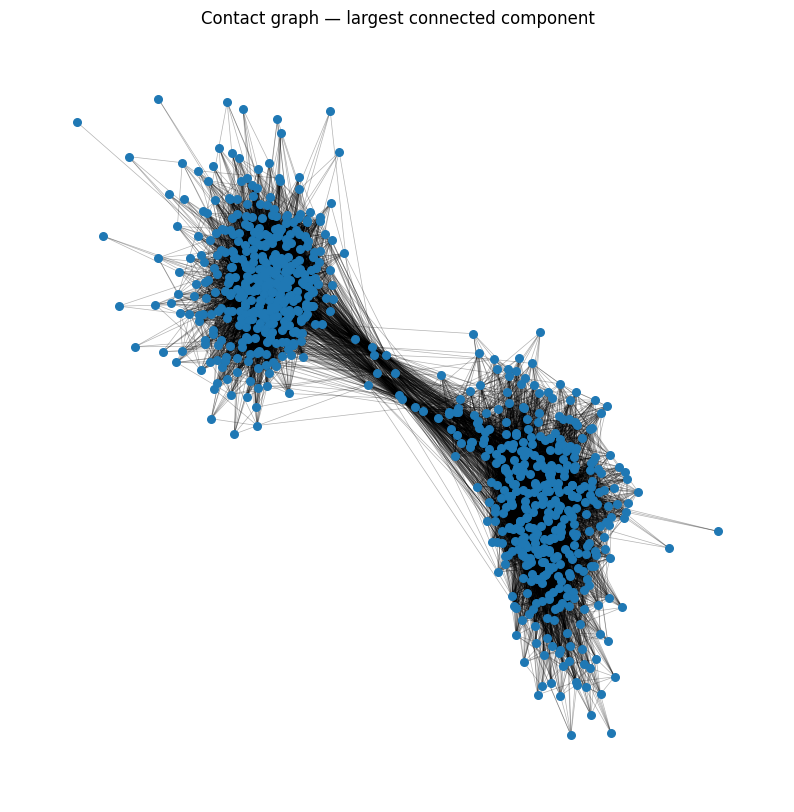

In [6]:
#Visualize graph (spring layout).
plt.figure(figsize=(10,10))
pos = nx.spring_layout(Gc, seed=42)  # stable layout
nx.draw_networkx_nodes(Gc, pos, node_size=30)
nx.draw_networkx_edges(Gc, pos, alpha=0.3, width=0.5)
plt.title("Contact graph — largest connected component")
plt.axis('off')
plt.show()

Top nodes by degree:
1599 169
1688 168
1655 163
1441 158
1825 156
275 128
1458 127
1485 125
267 124
1617 124

Top nodes by closeness:
1485 0.5351
1518 0.5344
1512 0.5266
1492 0.519
1543 0.5159
1894 0.508
1819 0.4997
1805 0.4935
1519 0.4877
1204 0.48

Top nodes by betweenness:
1485 0.0996
1518 0.0805
1492 0.073
1512 0.0644
1543 0.054
1894 0.0331
1819 0.0323
1519 0.0298
1655 0.0203
1805 0.0173


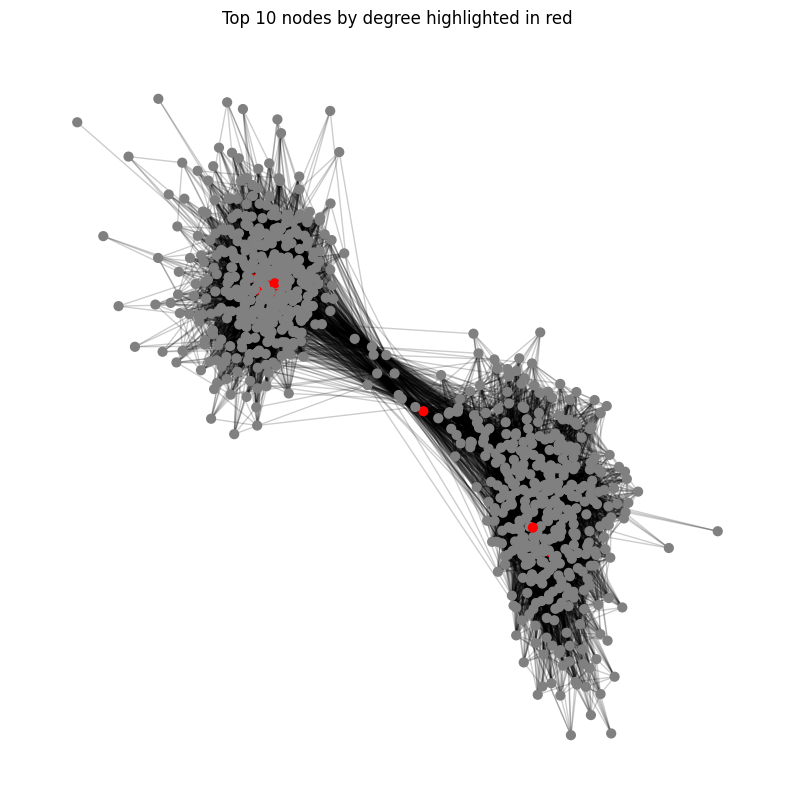

In [7]:
# Centrality computations and display top-k
top_k = 10

deg = dict(nx.degree(Gc))
closeness = nx.closeness_centrality(Gc)
betweenness = nx.betweenness_centrality(Gc, normalized=True, endpoints=False)

def top_n(d, n=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:n]

print("Top nodes by degree:")
for node, score in top_n(deg, top_k):
    print(node, score)

print("\nTop nodes by closeness:")
for node, score in top_n(closeness, top_k):
    print(node, round(score,4))

print("\nTop nodes by betweenness:")
for node, score in top_n(betweenness, top_k):
    print(node, round(score,4))

# Visual: highlight top-degree nodes
top_degree_nodes = [n for n,_ in top_n(deg, top_k)]
node_colors = ['red' if n in top_degree_nodes else 'gray' for n in Gc.nodes()]
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(Gc, pos, node_size=40, node_color=node_colors)
nx.draw_networkx_edges(Gc, pos, alpha=0.2)
plt.title(f"Top {top_k} nodes by degree highlighted in red")
plt.axis('off')
plt.show()

Number of communities detected: 3
Community sizes (largest first): [(1, 392), (0, 265), (2, 137)]


/tmp/ipython-input-3674959825.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_comms))


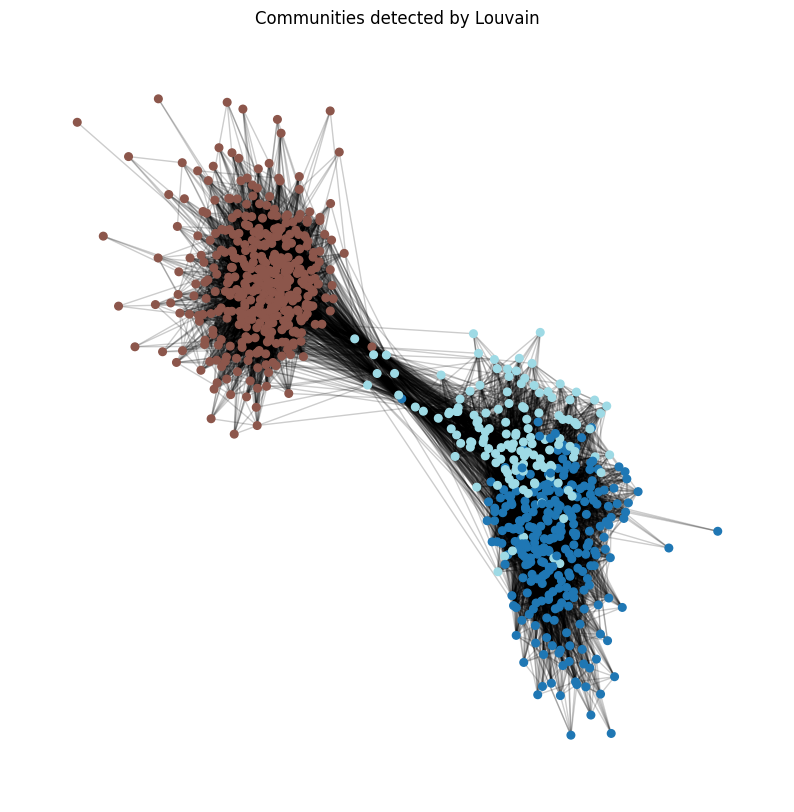

In [8]:
# Community detection (Louvain)
partition = community_louvain.best_partition(Gc)  # dictionary node -> community id
# count communities
from collections import Counter
comm_counts = Counter(partition.values())
print("Number of communities detected:", len(comm_counts))
print("Community sizes (largest first):", comm_counts.most_common(10))

# add community as node attribute
nx.set_node_attributes(Gc, partition, 'community')

# color nodes by community for visualization (large graphs -> limit to top communities)
unique_comms = list(set(partition.values()))
# map community -> color index
cmap = plt.cm.get_cmap('tab20', len(unique_comms))
node_colors = [cmap(unique_comms.index(partition[n])) for n in Gc.nodes()]

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(Gc, pos, node_size=30, node_color=node_colors)
nx.draw_networkx_edges(Gc, pos, alpha=0.2)
plt.title("Communities detected by Louvain")
plt.axis('off')
plt.show()

In [10]:
# Prepare positive and negative samples for link prediction
import random
random.seed(42)
np.random.seed(42)

G_lp = Gc.copy()
all_edges = list(G_lp.edges())

# Identify bridge edges (removing them would disconnect the graph)
bridges = set(nx.bridges(G_lp))
non_bridge_edges = [e for e in all_edges if e not in bridges and (e[1], e[0]) not in bridges]

print("Total edges:", len(all_edges))
print("Bridges:", len(bridges))
print("Removable (non-bridge) edges:", len(non_bridge_edges))

# Select 20% of edges (non-bridges) as test positives
test_frac = 0.2
num_test_pos = max(1, int(len(all_edges) * test_frac))
test_pos_edges = random.sample(non_bridge_edges, num_test_pos)

# Create training graph by removing test edges
G_train = G_lp.copy()
G_train.remove_edges_from(test_pos_edges)

print("Training edges:", G_train.number_of_edges())
print("Testing positive edges:", len(test_pos_edges))

# Generate negative edges (pairs of nodes not connected)
non_edges = list(nx.non_edges(G_train))
test_neg_edges = random.sample(non_edges, len(test_pos_edges))

print("Testing negative edges:", len(test_neg_edges))


Total edges: 20018
Bridges: 1
Removable (non-bridge) edges: 20017
Training edges: 16015
Testing positive edges: 4003
Testing negative edges: 4003


In [11]:
# Heuristic link predictors and evaluation
def predict_scores_heuristic(G, edge_list, method='common_neighbors'):
    scores = []
    if method == 'common_neighbors':
        for u,v in edge_list:
            cn = len(list(nx.common_neighbors(G, u, v)))
            scores.append(cn)
    elif method == 'jaccard':
        for u,v in edge_list:
            # Jaccard coefficient generator returns (u,v,score)
            jc = next(nx.jaccard_coefficient(G, [(u,v)]))[2]
            scores.append(jc)
    elif method == 'adamic_adar':
        for u,v in edge_list:
            aa = next(nx.adamic_adar_index(G, [(u,v)]))[2]
            scores.append(aa)
    elif method == 'pref_attachment':
        for u,v in edge_list:
            pa = next(nx.preferential_attachment(G, [(u,v)]))[2]
            scores.append(pa)
    elif method == 'resource_allocation':
        for u,v in edge_list:
            ra = next(nx.resource_allocation_index(G, [(u,v)]))[2]
            scores.append(ra)
    else:
        raise ValueError("Unknown method")
    return np.array(scores, dtype=float)

# prepare test lists
test_pos = test_pos_edges
test_neg = test_neg_edges
test_pairs = test_pos + test_neg
y_true = np.array([1]*len(test_pos) + [0]*len(test_neg))

methods = ['common_neighbors','jaccard','adamic_adar','pref_attachment','resource_allocation']
results = {}
for m in methods:
    scores = predict_scores_heuristic(G_train, test_pairs, method=m)
    # some methods produce all zeros for sparse graphs; but AUC handles that
    try:
        auc = roc_auc_score(y_true, scores)
        ap = average_precision_score(y_true, scores)
    except Exception as e:
        auc = None
        ap = None
    results[m] = {'auc': auc, 'ap': ap}
    print(f"{m}: AUC={auc}, AP={ap}")

# Summary
import pandas as pd
print("\nSummary:")
display(pd.DataFrame(results).T)


common_neighbors: AUC=0.9118299921074682, AP=0.8875488670082508
jaccard: AUC=0.9116720728252211, AP=0.9004727529576642
adamic_adar: AUC=0.9144782057973133, AP=0.8967568959929767
pref_attachment: AUC=0.7132462606579915, AP=0.6905362661320478
resource_allocation: AUC=0.9174316801744182, AP=0.900834284621679

Summary:


,auc,ap
common_neighbors,0.911830,0.887549
jaccard,0.911672,0.900473
adamic_adar,0.914478,0.896757
pref_attachment,0.713246,0.690536
resource_allocation,0.917432,0.900834


In [13]:
# Node2Vec embeddings + logistic regression classifier
# Create node2vec walks on G_train and learn embeddings, then create feature vectors for node-pairs by concatenation or Hadamard.
node2vec = Node2Vec(G_train, dimensions=64, walk_length=30, num_walks=100, workers=2, seed=42)
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # gensim Word2Vec model

# Build embedding dict
emb = {str(n): model.wv.get_vector(str(n)) if str(n) in model.wv else np.zeros(64) for n in G_train.nodes()}

def pair_features(u, v, emb, method='hadamard'):
    eu = emb[str(u)]
    ev = emb[str(v)]
    if method == 'hadamard':
        return eu * ev
    elif method == 'concat':
        return np.concatenate([eu, ev])
    elif method == 'average':
        return (eu + ev) / 2.0
    elif method == 'absdiff':
        return np.abs(eu - ev)
    else:
        raise ValueError("Unknown method")

# create feature matrix for classifier (use concat or hadamard)
feat_method = 'hadamard'
X = np.vstack([pair_features(u,v,emb, feat_method) for (u,v) in test_pairs])
y = y_true

# Train/test split for classifier demonstration: we'll split test_pairs into classifier train/test
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_clf, y_train_clf)
y_scores = clf.predict_proba(X_test_clf)[:,1]
auc_clf = roc_auc_score(y_test_clf, y_scores)
ap_clf = average_precision_score(y_test_clf, y_scores)
print("Node2Vec + LogisticRegression: AUC=", auc_clf, "AP=", ap_clf)


Computing transition probabilities:   0%|          | 0/794 [00:00<?, ?it/s]

Node2Vec + LogisticRegression: AUC= 0.8364143352898976 AP= 0.7955640058768904


In [14]:
# Precision@K helper and applying to all methods
def precision_at_k(y_true, scores, k):
    # returns precision among top-k predicted edges by score
    idx = np.argsort(scores)[::-1][:k]
    return np.mean(y_true[idx])

K = 50  # choose K meaningful for your test size
eval_table = []
for m in methods:
    scores = predict_scores_heuristic(G_train, test_pairs, method=m)
    auc = roc_auc_score(y_true, scores)
    ap = average_precision_score(y_true, scores)
    pk = precision_at_k(y_true, scores, min(K, len(scores)))
    eval_table.append({'method': m, 'auc': auc, 'ap': ap, 'prec@K': pk})

# Add embedding classifier result
# For embedding classifier, compute on all test_pairs (not sampled split). For fairness, using classifier on X built from test_pairs.
X_all = np.vstack([pair_features(u,v,emb, feat_method) for (u,v) in test_pairs])
clf_scores_all = clf.predict_proba(X_all)[:,1]
eval_table.append({'method': 'node2vec_logreg', 'auc': roc_auc_score(y_true, clf_scores_all), 'ap': average_precision_score(y_true, clf_scores_all), 'prec@K': precision_at_k(y_true, clf_scores_all, min(K, len(clf_scores_all)))})

eval_df = pd.DataFrame(eval_table).sort_values('auc', ascending=False)
display(eval_df)


,method,auc,ap,prec@K
4,resource_allocation,0.917432,0.900834,0.98
2,adamic_adar,0.914478,0.896757,0.98
0,common_neighbors,0.911830,0.887549,0.96
1,jaccard,0.911672,0.900473,1.00
5,node2vec_logreg,0.836270,0.794486,0.96
3,pref_attachment,0.713246,0.690536,0.86


Best method according to AUC: resource_allocation


/tmp/ipython-input-85638273.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_train, pos, edgelist=[(u,v)], width=2.0, style=linestyle, alpha=0.8)


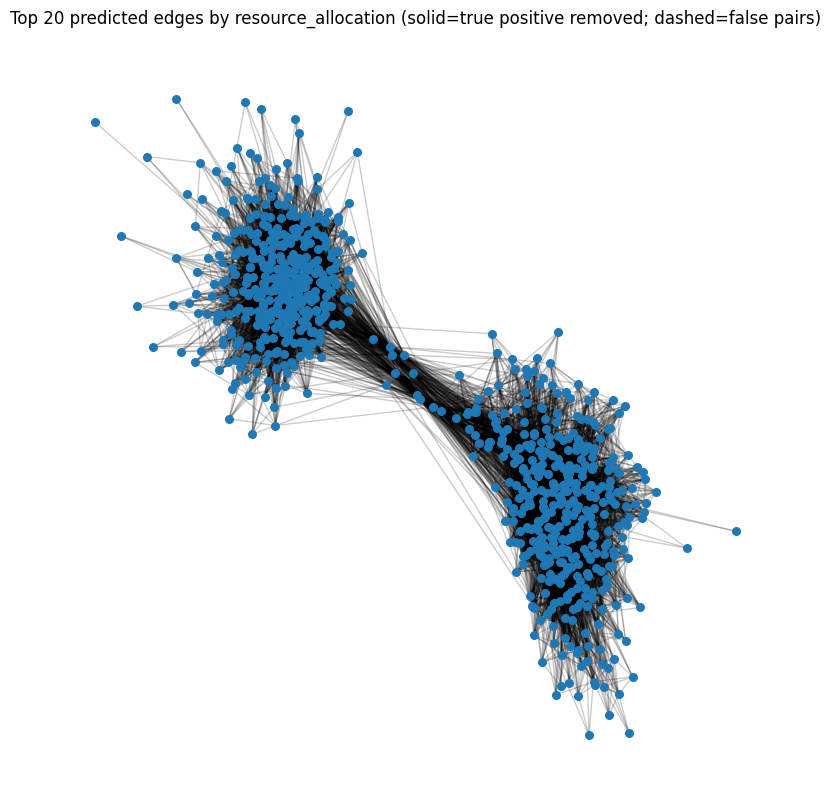

1441 - 1857 | score=1.4006 | true_label=1
1688 - 1684 | score=1.0477 | true_label=1
160 - 884 | score=1.0089 | true_label=1
1825 - 1458 | score=1.0080 | true_label=0
1579 - 1688 | score=0.9701 | true_label=1
147 - 3 | score=0.9421 | true_label=1
80 - 285 | score=0.9054 | true_label=1
387 - 376 | score=0.8959 | true_label=1
1562 - 1825 | score=0.8903 | true_label=1
1761 - 1688 | score=0.8702 | true_label=1
1582 - 1825 | score=0.8577 | true_label=1
1518 - 1401 | score=0.8559 | true_label=1
295 - 884 | score=0.8427 | true_label=1
706 - 285 | score=0.8275 | true_label=1
20 - 290 | score=0.8252 | true_label=1
372 - 884 | score=0.8205 | true_label=1
119 - 63 | score=0.8191 | true_label=1
1655 - 1786 | score=0.8162 | true_label=1
1518 - 376 | score=0.8137 | true_label=1
272 - 275 | score=0.7892 | true_label=1


In [15]:
# Visualize top predicted missing links (example using best heuristic)
best_method = eval_df.iloc[0]['method']
print("Best method according to AUC:", best_method)

if best_method == 'node2vec_logreg':
    scores = clf_scores_all
else:
    scores = predict_scores_heuristic(G_train, test_pairs, method=best_method)

# show top predicted positive pairs that are actually negative (i.e., high-score non-edge) or top missing edges
pairs_scores = list(zip(test_pairs, scores, y_true))
pairs_scores_sorted = sorted(pairs_scores, key=lambda x: x[1], reverse=True)
top_show = pairs_scores_sorted[:20]

# Make a small visualization on training graph, drawing predicted links as dashed lines
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G_train, pos, node_size=30)
nx.draw_networkx_edges(G_train, pos, alpha=0.2)
# highlight top predicted pairs as red dashed lines
for (u,v), score, label in top_show:
    # draw predicted edge (u,v)
    if label == 1:
        linestyle='-'  # it's truly positive (we removed it), expect recovery
    else:
        linestyle='--'  # it's a negative (false positive candidate)
    nx.draw_networkx_edges(G_train, pos, edgelist=[(u,v)], width=2.0, style=linestyle, alpha=0.8)
plt.title(f"Top {len(top_show)} predicted edges by {best_method} (solid=true positive removed; dashed=false pairs)")
plt.axis('off')
plt.show()

# print top predictions with labels
for (u,v),score,label in top_show:
    print(f"{u} - {v} | score={score:.4f} | true_label={label}")
